In [372]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from scipy.stats import chi2_contingency

# SQL Challenge

In [373]:
# establish a connection to the database by creating cursor object 
connection = psycopg2.connect(host = "drona.db.elephantsql.com", port = 5432, database = "drkctwgf", 
                              user = "drkctwgf", password = "CCs_bf9UxHgtUwP-EDVRmduuymmTQAss")
# create a cursor object 
cur = connection.cursor()
# sample query of all data from loans
cur.execute("""SELECT * FROM loans LIMIT 5""")
query_results = cur.fetchall()

In [374]:
# use python function pd.read_sql_query to save query as dataframe 
query = """SELECT * FROM loans LIMIT 5 """
loan_info = pd.read_sql_query(query,connection)
loan_info

,id,created,loan_status,user_id,amount
0,66,2017-04-08 19:22:00,repaid,1,240
1,181,2017-12-30 00:42:00,repaid,1,240
2,182,2017-12-30 01:54:00,repaid,1,240
3,132,2017-07-05 12:08:00,approved,211,240
4,183,2017-12-30 01:54:00,approved,1,240


In [375]:
query2 = "SELECT * FROM transactions LIMIT 3"
transact_info = pd.read_sql_query(query2,connection)
transact_info

,transaction.id,created,loan_id,user_id,transaction_fee,t_type,transaction.amount
0,1530,2020-04-27,1863,2339,15,disbursement,316
1,1539,2020-04-28,1878,2339,8,disbursement,10
2,1546,2020-04-28,1885,2345,15,disbursement,316


In [376]:
query3 = "SELECT * FROM users LIMIT 5"
users_info = pd.read_sql_query(query3, connection)
users_info

,id,created
0,105,2017-04-12 10:26
1,258,2017-10-27 21:00
2,167,2017-05-24 03:18
3,2247,2020-03-19 13:47
4,262,2017-10-27 13:40


Query every loan that was withdrawn (this is very important - it's every loan, not every user
We want to know the loan `amount`,  `user_id`, `user.created` and the `transaction_fee` charged for the **transaction of type `disbursement`**
Order these results by the date of the customer account created - going by newest first

In [378]:


query4 = ''' WITH a AS (SELECT * FROM transactions as t  INNER JOIN users ON t.user_id = users.id 
            WHERE t.t_type LIKE '%disbursement%'
            ) , b AS (SELECT * FROM loans WHERE loans.loan_status 
            LIKE '%repaid%' OR loans.loan_status LIKE '%active%')
            SELECT * FROM a INNER JOIN b ON a.loan_id = b.id ORDER BY b.created DESC
     '''
join_table = pd.read_sql_query(query4,connection)
join_table = join_table.loc[:, ['transaction.id','created','loan_id', 'user_id', 'transaction_fee', 'transaction.amount', 'loan_status']]
join_table


,transaction.id,created,created,created,loan_id,user_id,user_id,transaction_fee,transaction.amount,loan_status
0,1520,2020-04-24,2020-04-24 12:26,2020-04-24 12:42:00,1857,2339,2339,15,316,active
1,1498,2020-04-15,2020-04-15 13:14,2020-04-15 15:20:00,1812,2296,2296,15,316,active
2,1446,2020-03-30,2020-01-22 19:39,2020-03-29 15:24:00,1736,2140,2140,15,316,repaid
3,1378,2020-01-29,2020-01-22 19:39,2020-01-29 17:08:00,1533,2140,2140,22,316,repaid
4,1376,2020-01-29,2020-01-22 19:39,2020-01-29 15:50:00,1532,2140,2140,15,316,repaid
5,1365,2020-01-24,2020-01-22 19:39,2020-01-24 15:09:00,1522,2140,2140,8,232,repaid
6,1351,2020-01-22,2020-01-22 19:39,2020-01-22 19:52:00,1516,2140,2140,15,316,repaid
7,1342,2020-01-15,2019-08-15 13:36,2020-01-15 12:36:00,1505,1571,1571,15,528,active
8,1301,2019-12-16,2019-08-15 13:36,2019-11-25 09:19:00,1416,1571,1571,15,440,repaid
9,1108,2019-10-21,2019-08-15 13:36,2019-10-21 12:12:00,1314,1571,1571,15,240,repaid


From the loans table, show:

 >number of loans per month
 total `amount` of all loans per month,
 average amount of each loan per month,
 smallest loan size per month,
 largest loan size per month,
 order by most recent month first

In [380]:
query5 = ''' SELECT EXTRACT(MONTH from created) as Month_n, SUM(amount) as total_amount, 
        AVG(amount) as average_amount, MIN(amount) as min_amount, MAX(amount) as max_amount
        FROM loans GROUP BY Month_n ORDER BY Month_n'''
loans_table = pd.read_sql_query(query5,connection, )
loans_table

,month_n,total_amount,average_amount,min_amount,max_amount
0,1.0,1908,318.000000,200,528
1,2.0,240,240.000000,240,240
2,3.0,1509,150.900000,1,528
3,4.0,2897,193.133333,10,1000
4,5.0,880,293.333333,240,400
5,7.0,240,240.000000,240,240
6,8.0,480,240.000000,240,240
7,10.0,640,320.000000,240,400
8,11.0,440,440.000000,440,440
9,12.0,720,240.000000,240,240


# Python Challenge 
- In the provided `weekly_logins` table you have activity on all the logins taking place
- The question that we are looking to answer is: what categories or groups here had high engagement (weekly logins) levels?
- Use whatever tools you need to answer this question, and please take this as an opportunity to display your analytical and technical skills
- Please elaborate on your reasoning for decisions made when analyzing the data set by providing your analysis

In [381]:
df = pd.read_csv('weekly_logins.csv')
df.head(5)

,User Name,Slack Integration,Most Used Page,Had Free Trial,User MRR,Weekly Logins,Company Name,Industry,Company Size,Territory,Sales Call in Trial,Zendesk Integration,Salesforce Integration,Gmail Integration,Most common referrer,Most common IP,Sales Touches to Close,Used Admin Panel,Has Issued Support Request
0,Nilsa Harmon,No,/home,No,39,2,HP,Technology,>$10B,West,No,Yes,No,Yes,hotels.com,165.227.215.62,5,No,No
1,Joni Catano,No,/tool/storyboard,No,39,6,HP,Technology,>$10B,West,No,Yes,Yes,No,hotels.com,159.203.166.41,16,No,Yes
2,Emmett Jeffries,Yes,/tool/search,Yes,169,3,HP,Technology,>$10B,West,Yes,No,Yes,No,hotels.com,159.203.166.41,4,No,Yes
3,Dian Boisse,No,/tool/storyboard,No,39,2,HP,Technology,>$10B,West,No,Yes,No,No,zoom.com,162.243.108.129,15,No,Yes
4,Barbara Herrera,No,/tool/storyboard,No,1299,7,HP,Technology,>$10B,West,No,No,Yes,No,/mail.google.com,159.203.166.41,5,No,Yes


In [382]:
len(df)

1718

In [384]:
company_df = df.groupby(["Company Name","Company Size"])['Weekly Logins'].agg(['sum','median','mean','max','min']).rename(columns={
    'sum':'Sum Weekly Logins','median':'Median Weekly Login per Person','mean': 'Mean Weekly Login per Person', 
    'max': 'Max Weekly Logins per Person', 'min': 'Min Weekly Login per Person'}).reset_index().sort_values(by = 'Sum Weekly Logins', axis = 0, ascending = False)
company_df.head(5)

,Company Name,Company Size,Sum Weekly Logins,Median Weekly Login per Person,Mean Weekly Login per Person,Max Weekly Logins per Person,Min Weekly Login per Person
19,Worldsource Wealth Management,$100M - $500M,895,5.0,6.532847,16,0
13,US Soccer Federation,<$100M,867,5.0,6.518797,16,0
16,Visa,>$10B,774,5.0,5.375000,17,0
8,Siemon,$100M - $500M,744,5.0,6.305085,17,0
11,"TaxSlayer, LLC",<$100M,597,5.0,5.970000,16,0


Text(0.5, 1.0, 'Sum of Weekly Logins by Company')

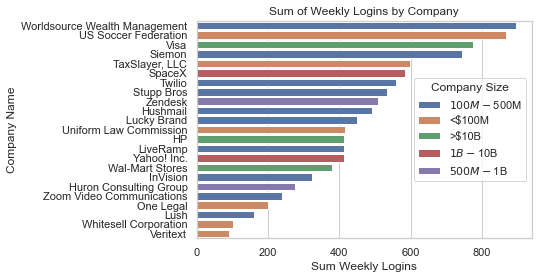

In [385]:

comp = sns.barplot(x = 'Sum Weekly Logins', y = 'Company Name', data = company_df, hue = "Company Size", dodge = False)
comp.set_title('Sum of Weekly Logins by Company')


Users belonging to the companies Worldsource Wealth Management, US Soccer Federation, Visa, Siemon, and TaxSlayer have the top 5 highest sum of weekly logins. Worldsource Wealth Management has the highest sum of weekly logins with 895 followed by US Soccer Federation with 867, Visa with 774, Siemon with 774, and Taxslayer with 567. From the legend for Company Size, there doesn't seem to be a strong link between Sum of Weekly Logins and Company Size. For example, there are three different company sizes represented in the top 5 Companies by Sum of Weekly Logins. In addition, there are no systematic groupings of Companies by Company size when ranked according to sum of weekly logins. However, in 5 out of the top 10 companies ranked by weekly logins, the company size ranged from $100M-$500M.  

Text(0.5, 1.0, 'Distribution of Weekly Logins Per User by Company')

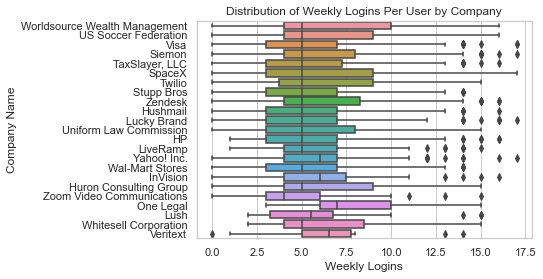

In [386]:
order_of_comp = pd.unique(company_df["Company Name"])

comp2 = sns.boxplot(x= "Weekly Logins", y = "Company Name", order = order_of_comp, data = df)
comp2.set_title("Distribution of Weekly Logins Per User by Company")

the majority of the companies, 17/23,  have a median login of 5 per user from each company. The companies vary in interquartile range and some have weekly login outliers for some users in companies such as Visa, Siemon, LiveRamp and HP among many othes. The companies towards the bottom, those with lower total sum of weekly logins, tend to have smaller interquartile ranges and fewer outliers such as in Veritext, Zoom Video, and Lush. 

In [389]:
Industry_df = df.groupby("Industry")['Weekly Logins'].agg(['sum','median','mean','max','min']).rename(columns={
    'sum':'Sum Weekly Logins','median':'Median Weekly Login per Person','mean': 'Mean Weekly Login per Person', 
    'max': 'Max Weekly Logins per Person', 'min': 'Min Weekly Login per Person'}).reset_index().sort_values(by = 'Sum Weekly Logins', axis = 0, ascending = False)
Industry_df

,Industry,Sum Weekly Logins,Median Weekly Login per Person,Mean Weekly Login per Person,Max Weekly Logins per Person,Min Weekly Login per Person
7,Technology,5313,5,5.936313,17,0
4,Manufacturing,1378,5,5.914163,17,0
2,Hospitality,958,6,6.517007,16,0
1,Finance,895,5,6.532847,16,0
3,Legal Services,615,5,6.275510,15,0
0,Consumer Products,608,5,6.141414,17,0
5,Other,380,5,5.671642,14,0
6,Professional Services,274,5,6.523810,15,0


Industry
Consumer Products         99
Finance                  137
Hospitality              147
Legal Services            98
Manufacturing            233
Other                     67
Professional Services     42
Technology               895
Name: Company Name, dtype: int64

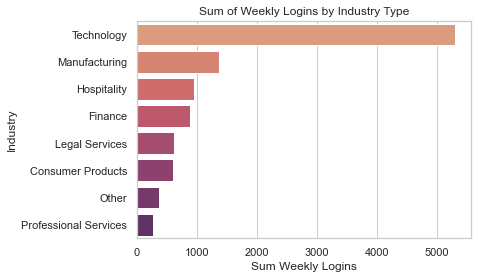

In [390]:
industry = sns.barplot(x = 'Sum Weekly Logins', y = 'Industry', data = Industry_df, palette = "flare")
industry.set_title('Sum of Weekly Logins by Industry Type')
df.groupby("Industry")["Company Name"].count()

The sum of weeky logins for technology is more than twice as high as the second most industry, manufacturing with 5313 total weekly logins for technology and 1378 weekly logins for manufacturing. The majority of the users 895/1718 or about 52% come from technology industry followed by 13% from manufacturing, 8% from finance, 8.5% from hospitality, 5.7% from legal services. The ranking of the industry by sum of weekly logins mirrors almost exactly the ranking of industry by count of users belonging to the respective industry. 

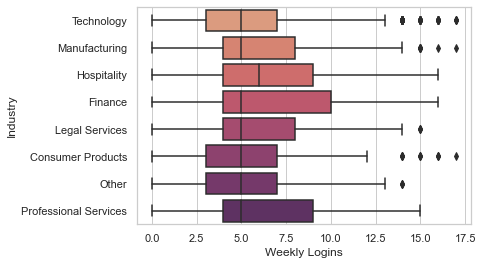

In [360]:
industry_order = pd.unique(Industry_df["Industry"])
industry_boxplot = sns.boxplot(x = 'Weekly Logins', y = 'Industry', data = df, order = industry_order, palette = "flare")

From the boxplots of of weekly user logins across industries we observe no large differences in the distribution of weekly logins per user. All of the industries except Hospitality have median weekly login per user of 5 and Finance has the highest interquartile range. Some industries such has Technology, Manufacturing, and Comsumer Produces have notable outliers for weekly logins ranging from 12.5 to 17.5. 

In [391]:
# matrices showing sum of weekly logins across different platform integrations
slack_integ = np.transpose(df.groupby("Slack Integration")["Weekly Logins"].agg(["sum"]).reset_index().to_numpy())
zendesk_integ = np.transpose(df.groupby("Zendesk Integration")["Weekly Logins"].agg(["sum"]).reset_index().to_numpy())
gmail_integ = np.transpose(df.groupby("Gmail Integration")["Weekly Logins"].agg(["sum"]).reset_index().to_numpy())
salesforce_integ = np.transpose(df.groupby("Salesforce Integration")["Weekly Logins"].agg(["sum"]).reset_index().to_numpy())
print(salesforce_integ)

[['No' 'Yes']
 [6050 4371]]


In [392]:
headers = ["Slack", "Zendesk", "Gmail","Salesforce"]
platforms = [slack_integ, zendesk_integ, gmail_integ, salesforce_integ]
yes = [] 
no = []
for platform in platforms:
    yes.append(platform[1][1]) 
    no.append(platform[1][0])
platform_integrations = pd.DataFrame(np.c_[no,yes], index = headers).rename(columns = {0:'No', 1:'Yes'})
platform_integrations

,No,Yes
Slack,5962,4459
Zendesk,4750,5671
Gmail,4786,5635
Salesforce,6050,4371


Text(0, 0.5, 'Sum of Weekly Logins')

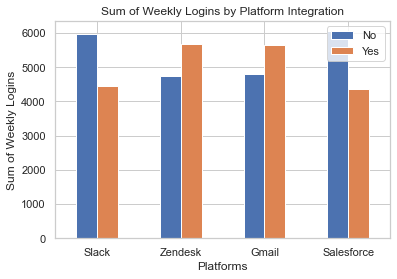

In [393]:
platform_integrations.plot.bar(rot =0)
plt.title("Sum of Weekly Logins by Platform Integration")
plt.xlabel("Platforms")
plt.ylabel("Sum of Weekly Logins")

In [394]:
# Chi-squared test of independence
# null hypothesis: There is no significant difference in sum of weekly logins based on whether
# the platform is integrated or not. (test of independence)
c, p, dof, expected = chi2_contingency(platform_integrations)
p

1.0441462137320218e-127

Across users who didn't have Slack or Salesforce integration, the total sum of weekly logins was largest with a total of 5962 and 6050 weekly logins for non-slack and non-salesforce users. On the contrary, the total sum of weekly logins was smallest for users who had Slack and Salesforce Integration. For users who have Zendesk or Gmail integrated, the sum of weekly logins was higher for both platform integrations then for users who did't have these platforms integrated. 
From eyeing the barchart alone, there seems to be a large difference in sum of weekly logins between integrated platforms vs. non-integrated platforms. Furthermore, our p-value of nearly 0 tells us that the difference in weekly logins is not independent of whether or not the users platform is integrated. However, the chi-squared test doesn't tell us the direction of the relationship- whether or not the sum of weekly logins are systematically higher or lower for integrated platforms vs. non-integrated platforms 